In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import scipy.integrate as teg
import netCDF4 as nc
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'Dejavu Serif'

In [41]:
# i/o params
loc = "/scratch/hcm7920/ambData/channelMean/"
loc2= "/scratch/hcm7920/amb0/data/"
loc3 = "/home/hcm7920/experiments/arcticMiddepthBI/plots/officialFigs/"
conc = [0,20,40,60,80,100]

# grid params
nx = 500
ny = 500
nz = 50

# phys params
g = 9.81
rhoConst = 1000
cellArea = (2e3)**2
sFac = 7.4e-4 * rhoConst * -g / rhoConst # for clarity

In [42]:
# load
rhoSteady = np.load(loc+"channelMeanRho.npy")
n2Steady  = np.load(loc+"channelMeanN2.npy")
saltSteady= np.load(loc+"channelMeanSalt.npy")
uSteady   = np.load(loc+"channelMeanU.npy")
vSteady   = np.load(loc+"channelMeanV.npy")
wSteady   = np.load(loc+"channelMeanW.npy")

# vsBar     = np.load(loc+"channelMeanVSbar.npy")
# wsBar     = np.load(loc+"channelMeanWSbar.npy")
# vrBar     = np.load(loc+"channelMeanVRbar.npy")
# wrBar     = np.load(loc+"channelMeanWRbar.npy")

wsBarFlx = np.load(loc+"channelMeanAdvSltFlxZ.npy")
vsBarFlx = np.load(loc+"channelMeanAdvSltFlxY.npy")

saltForcing = np.load(loc+"channelMeanSaltForcing.npy")
UmomForcing = np.load(loc+"channelMeanUmomForcing.npy")
VmomForcing = np.load(loc+"channelMeanVmomForcing.npy")
saltTend    = np.load(loc+"channelMeanSaltTendency.npy")

diffSalt = np.load(loc+"channelMeanDiffSaltIbar.npy")
diffSalt /= cellArea

ghatSalt = np.load(loc+"channelMeanNonLocal.npy")
ghatSalt /= cellArea

levs = nc.Dataset(loc2+"grid.nc")["Z"][:]
levFaces = nc.Dataset(loc2+"grid.nc")["Zp1"][:]
deltaFaces = nc.Dataset(loc2+"grid.nc")["drF"][:]
deltaCentr = nc.Dataset(loc2+"grid.nc")["drC"][:]

In [43]:
# pad some arrays as necessary

saltSteady = np.pad(saltSteady,((0,0),(0,1),(0,0)),mode="edge")
diffSalt = np.pad(diffSalt,((0,1),(0,0),(0,0)),mode="constant",constant_values=0)
wsBarFlx = np.pad(wsBarFlx,((0,1),(0,0),(0,0)),mode="constant",constant_values=0)


In [44]:
# calculate correlation terms

wsPrimeBar = wsBarFlx[:-1,:,:]/(2e3**2) - (wSteady*saltSteady[:,:-1,:])
wsPrimeBar = np.pad(wsPrimeBar,((0,1),(0,0),(0,0)),constant_values=0)
vsPrimeBar = vsBarFlx/(2e3*deltaFaces[:,np.newaxis,np.newaxis])-(vSteady*saltSteady)


In [45]:
# divergence of eddy adv terms

term1 = (vsPrimeBar[:,1:,:]-vsPrimeBar[:,:-1,:]) / 2000
term2 = (wsPrimeBar[:-1,:,:]-wsPrimeBar[1:,:,:]) / deltaFaces[:,None,None]
divAdvFlux = -term1 - term2


In [46]:
# divergence of total adv terms

term1 = (wsBarFlx[:-1,:,:]-wsBarFlx[1:,:,:]) / (deltaFaces[:,None,None]*2e3**2)
term2 = (vsBarFlx[:,1:,:]-vsBarFlx[:,:-1,:]) / (deltaFaces[:,None,None]*2e3**2)
divTotAdvFlux = -term1 - term2


In [47]:
# divergence of dif terms

divDiffFlux = -(diffSalt[:-1,:,:]-diffSalt[1:,:,:]) / deltaFaces[:,None,None]


In [48]:
# integrate the terms horizontally

intDivDiffFlux = teg.trapezoid(divDiffFlux,dx=2000,axis=1)
intDivAdvFlux = teg.trapezoid(divAdvFlux,dx=2000,axis=1)
intSaltForcing = teg.trapezoid(saltForcing,dx=2000,axis=1)
intSaltTend = teg.trapezoid(saltTend,dx=2000,axis=1)
intDivTotAdvFlux = teg.trapezoid(divTotAdvFlux,dx=2000,axis=1)


In [49]:
# divide by channel width to make an average
# scale by 1e7 for plotting cleanliness

intDivDiffFlux *= (1e7 / (2000*500))
intDivAdvFlux *= (1e7 / (2000*500))
intSaltForcing *= (1e7 / (2000*500))
intSaltTend *= (1e7 / (2000*500))
intDivTotAdvFlux *= (1e7 / (2000*500))


In [50]:
# sum the four terms however I need to

fluxes = intDivDiffFlux + intDivAdvFlux
meanflx = intDivTotAdvFlux - intDivAdvFlux


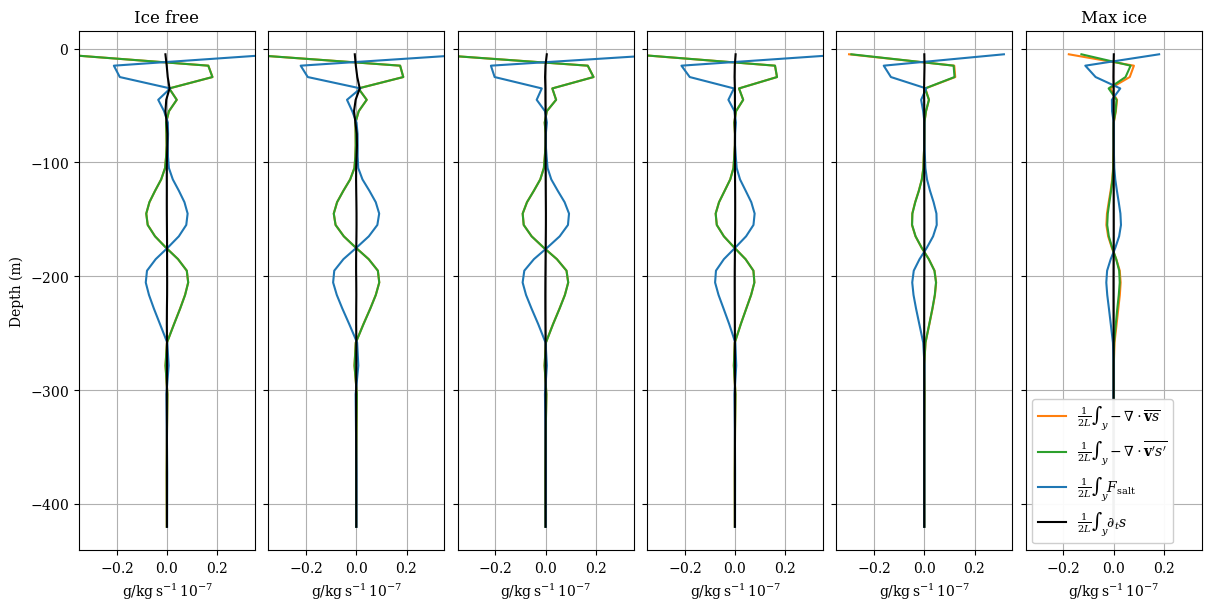

In [63]:
# make the official figure

sI = 0
dI = 30
selectedIndices = [0,1,2,3,4,5]
nConc = len(selectedIndices)

fig,ax = plt.subplots(1,nConc,sharey=True,layout="constrained",figsize=(12,6))

for i in range(nConc):
  cdex = selectedIndices[i]

  # ax[i].plot(intDivDiffFlux[sI:dI,cdex],levs[sI:dI],color="darkgreen",
  #          label="diffusive flux")
  ax[i].plot(intDivTotAdvFlux[sI:dI,cdex],levs[sI:dI],color="tab:orange",
           label=r"$\frac{1}{2L}\int_y-\nabla\cdot\overline{\mathbf{v}s}$")
  ax[i].plot(intDivAdvFlux[sI:dI,cdex],levs[sI:dI],color="tab:green",
           label=r"$\frac{1}{2L}\int_y-\nabla\cdot\overline{\mathbf{v}'s'}$")
  ax[i].plot(intSaltForcing[sI:dI,cdex],levs[sI:dI],color="tab:blue",
           label=r"$\frac{1}{2L}\int_y F_{\mathrm{salt}}$")
  ax[i].plot(intSaltTend[sI:dI,cdex],levs[sI:dI],color="black",
             label=r"$\frac{1}{2L}\int_y \partial_t s$")

  # if i == 0:
  #   ax[i].set_xlim([-0.5,0.5])
  # elif i == 1:
  #   ax[i].set_xlim([-0.25,0.25])

  ax[i].set_xlim([-0.35,0.35])
  ax[i].grid(visible=True,axis='both')
  ax[i].set_xlabel(r"$\mathrm{g}/\mathrm{kg}\,\mathrm{s}^{-1}\,{10}^{-7}$")

ax[0].set_ylabel("Depth (m)")
ax[0].set_title("Ice free")
ax[-1].set_title("Max ice")
ax[-1].legend(framealpha=0.95)

plt.savefig(loc3+"figAdvflux+Forcing.pdf", bbox_inches="tight")

In [52]:
# similar procedure in horizontal

In [53]:
# integrate the terms vertically

# intDivDiffFlux = teg.trapezoid(divDiffFlux,x=levs,axis=0)
# intDivAdvFlux = teg.trapezoid(divAdvFlux,x=levs,axis=0)
# intSaltForcing = teg.trapezoid(saltForcing,x=levs,axis=0)
# intSaltTend = teg.trapezoid(saltTend,x=levs,axis=0)
# intDivTotAdvFlux = teg.trapezoid(divTotAdvFlux,x=levs,axis=0)


In [54]:
# integrate differently: this time with simple rectangles...

# intDivDiffFlux = (divDiffFlux[:,:,:]*deltaFaces[:,None,None]).sum(axis=0)
# intDivAdvFlux = (divAdvFlux[:,:,:]*deltaFaces[:,None,None]).sum(axis=0)
# intSaltForcing = (saltForcing[:,:,:]*deltaFaces[:,None,None]).sum(axis=0)
# intSaltTend = (saltTend[:,:,:]*deltaFaces[:,None,None]).sum(axis=0)
# intDivTotAdvFlux = (divTotAdvFlux[:,:,:]*deltaFaces[:,None,None]).sum(axis=0)


In [55]:
# divide by channel depth to make an average

# intDivDiffFlux *= (1 / -levFaces[-1])
# intDivAdvFlux *= (1 / -levFaces[-1])
# intSaltForcing *= (1 / -levFaces[-1])
# intSaltTend *= (1 / -levFaces[-1])
# intDivTotAdvFlux *= (1 / -levFaces[-1])


In [56]:
# sum the four terms however I need to

# fluxes = intDivDiffFlux + intDivAdvFlux
# meanflx = intDivTotAdvFlux - intDivAdvFlux


In [57]:
# make the official figure, for the other dimension

# selectedIndices = [0,-1]
# xGrid = np.linspace(-499,499,500)

# fig,ax = plt.subplots(2,1,sharex=True,layout="constrained",figsize=(6,6))

# for i in range(2):
#   cdex = selectedIndices[i]

#   # ax[i].plot(xGrid,intDivDiffFlux[:,cdex],color="darkgreen",
#   #          label="diffusive flux")
#   ax[i].plot(xGrid,intDivTotAdvFlux[:,cdex],color="tab:orange",
#            label=r"$\frac{1}{H}\int_z-\nabla\cdot\overline{\mathbf{v}s}$")
#   ax[i].plot(xGrid,intDivAdvFlux[:,cdex],color="tab:green",
#            label=r"$\frac{1}{H}\int_z-\nabla\cdot\overline{\mathbf{v}'s'}$")
#   ax[i].plot(xGrid,intSaltForcing[:,cdex],color="tab:blue",
#            label=r"$\frac{1}{H}\int_z F_{\mathrm{salt}}$")
#   ax[i].plot(xGrid,intSaltTend[:,cdex],color="black",
#              label=r"$\frac{1}{H}\int_z \partial_t s$")

#   ax[i].grid(visible=True,axis='both')
#   ax[i].set_ylim(-4.5e-9,4.5e-9)
#   # ax[i].set_xlabel(r"$\mathrm{g}/\mathrm{kg}\,\mathrm{s}^{-1}\,{10}^{-7}$")

# ax[-1].set_xlabel("Across channel distance (km)")
# ax[0].set_title("Ice free",loc="right")
# ax[1].set_title("Max ice",loc="right")
# ax[1].legend(loc="lower left")

# plt.savefig(loc3+"figAdvflux+Forcing.pdf", bbox_inches="tight")